# PowerLine Binary Classifier - MNIST Style


https://towardsdatascience.com/image-classification-in-10-minutes-with-mnist-dataset-54c35b77a38d


Adaptation du modèle de classificateur multiclasse de MNIST pour le classificateur binaire du PowerLine Detection 

In [1]:
import tensorflow as tf
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
#(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

C:\Users\VArri\Documents\PowerLines\images\visuel\cropped
(2369, 28, 28)
(2369,)
0


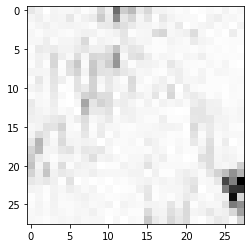

In [2]:
os.chdir(r"C:\Users\VArri\Documents\PowerLines\images\visuel\cropped")
path = os.getcwd()
print(path)

PL_path = os.path.join(path,'1')
noise_path = os.path.join(path,'0')
dirs_PL = os.listdir(PL_path)
dirs_noise = os.listdir(noise_path)

x_train = []
y_train = []

for pl in dirs_PL:
    x_train.append(cv2.imread(os.path.join(PL_path, pl), 0))
    y_train.append(1)
    
for noise in dirs_noise:
    x_train.append(cv2.imread(os.path.join(noise_path, noise), 0))
    y_train.append(0)

x_train = np.array(x_train).astype(np.uint8)
y_train = np.array(y_train).astype(np.uint8)

print(x_train.shape)
print(y_train.shape)

image_index = 2300 # You may select anything up to 60,000
print(y_train[image_index]) # The label is 8
plt.imshow(x_train[image_index], cmap='Greys')

C:\Users\VArri\Documents\PowerLines\images\visuel\cropped_test
(505, 28, 28)
(505,)
1


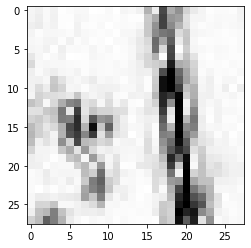

In [3]:
os.chdir(r"C:\Users\VArri\Documents\PowerLines\images\visuel\cropped_test")
path = os.getcwd()
print(path)

PL_path = os.path.join(path,'1')
noise_path = os.path.join(path,'0')
dirs_PL = os.listdir(PL_path)
dirs_noise = os.listdir(noise_path)

x_test = []
y_test = []

for pl in dirs_PL:
    x_test.append(cv2.imread(os.path.join(PL_path, pl), 0))
    y_test.append(1)
    
for noise in dirs_noise:
    x_test.append(cv2.imread(os.path.join(noise_path, noise), 0))
    y_test.append(0)

x_test = np.array(x_test).astype(np.uint8)
y_test = np.array(y_test).astype(np.uint8)

print(x_test.shape)
print(y_test.shape)

image_index = 100 # You may select anything up to 60,000
print(y_test[image_index]) # The label is 8
plt.imshow(x_test[image_index], cmap='Greys')

In [4]:
# Reshaping the array to 4-dims so that it can work with the Keras API
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
input_shape = (28, 28, 1)
# Making sure that the values are float so that we can get decimal points after division
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
# Normalizing the RGB codes by dividing it to the max RGB value.
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print('Number of images in x_train', x_train.shape[0])
print('Number of images in x_test', x_test.shape[0])

x_train shape: (2369, 28, 28, 1)
Number of images in x_train 2369
Number of images in x_test 505


In [5]:
from sklearn.utils import shuffle
x_train, y_train = shuffle(x_train, y_train)
x_test, y_test = shuffle(x_train, y_train)

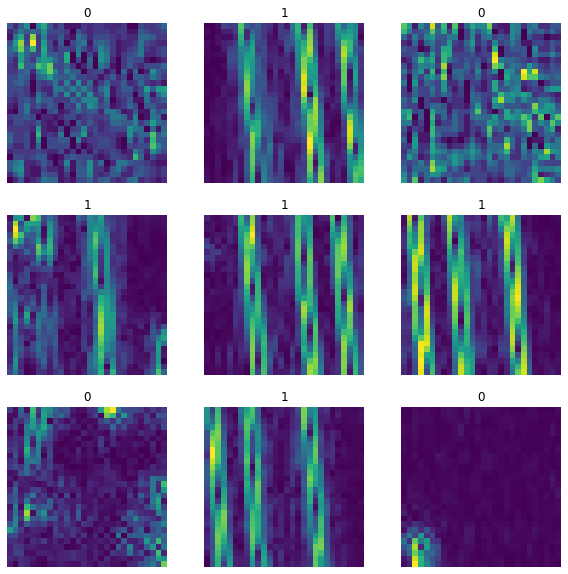

In [6]:
import matplotlib.pyplot as plt
from random import randrange
rank=randrange(0, x_train.shape[0])
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(x_train[rank+i])
    plt.title(y_train[rank+i])
    plt.axis("off")

In [7]:
import tensorflow.keras as keras
model = keras.models.Sequential([
    # keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=[28,28,1]),
    keras.layers.Conv2D(6, kernel_size=5, strides=1, padding="valid", input_shape=input_shape),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(12, kernel_size=5, strides=1, padding="valid"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(192),
    keras.layers.Dense(1, activation="sigmoid")
])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 6)         156       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 12)          1812      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 12)          0         
_________________________________________________________________
flatten (Flatten)            (None, 192)               0         
_________________________________________________________________
dense (Dense)                (None, 192)               37056     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1

In [9]:
epochs = 5

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

history = model.fit(x=x_train,y=y_train, epochs=epochs, verbose=1,validation_split=0.25, shuffle=True)

Epoch 1/5
56/56 [==============================] - 1s 15ms/step - loss: 0.4453 - accuracy: 0.7748 - val_loss: 0.2741 - val_accuracy: 0.8820
Epoch 2/5
56/56 [==============================] - 1s 15ms/step - loss: 0.2006 - accuracy: 0.9195 - val_loss: 0.1432 - val_accuracy: 0.9477
Epoch 3/5
56/56 [==============================] - 1s 14ms/step - loss: 0.1340 - accuracy: 0.9471 - val_loss: 0.0944 - val_accuracy: 0.9747
Epoch 4/5
56/56 [==============================] - 1s 14ms/step - loss: 0.0884 - accuracy: 0.9735 - val_loss: 0.0765 - val_accuracy: 0.9730
Epoch 5/5
56/56 [==============================] - 1s 14ms/step - loss: 0.0845 - accuracy: 0.9713 - val_loss: 0.1486 - val_accuracy: 0.9562


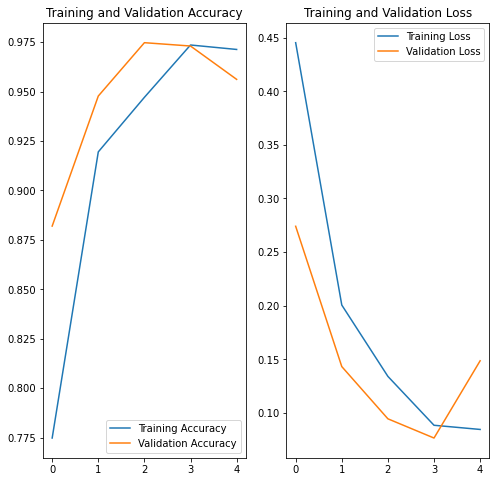

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [11]:
model.evaluate(x_test, y_test)

75/75 [==============================] - 1s 9ms/step - loss: 0.1295 - accuracy: 0.9603


[0.12948690354824066, 0.9603208303451538]

In [12]:
pred = model.predict(x_test)

4


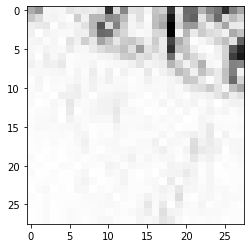

In [13]:
image_index = 444
plt.imshow(x_test[image_index].reshape(28, 28),cmap='Greys')
pred[image_index]
print(pred.argmax())

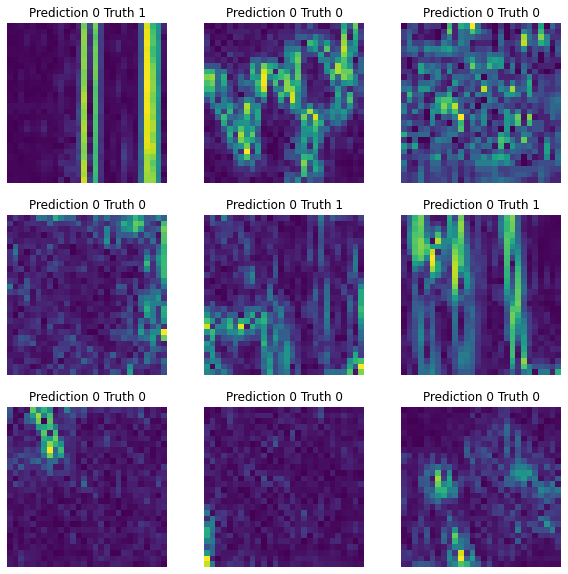

In [14]:
import matplotlib.pyplot as plt
from random import randrange

rank=randrange(0, x_test.shape[0])
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(x_test[rank+i])
    plt.title('Prediction {} Truth {}'.format(pred[rank+i].argmax(),y_test[rank+i]))
    plt.axis("off")